# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

d:\program\anaconda\envs\maskrcnn\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [2]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

## Create Model and Load Trained Weights

In [3]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [4]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (1487, 2035, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 2035.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


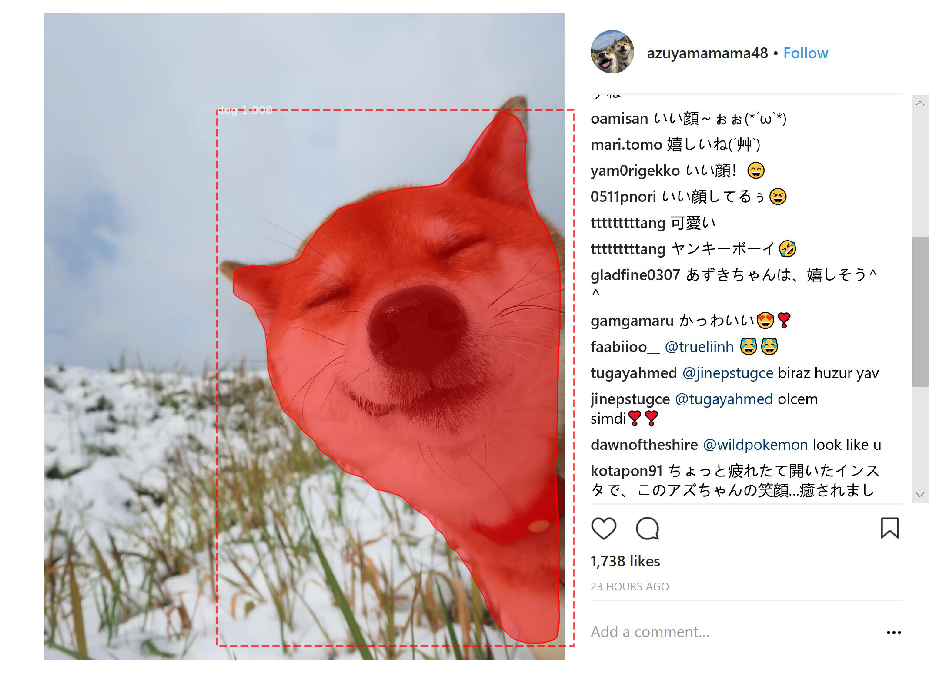

In [6]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
#image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))

filename=os.path.join(IMAGE_DIR,'dog.jpg')
image = skimage.io.imread(filename)

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [10]:
mkdir videos

子目录或文件 videos 已经存在。


In [16]:
ls ./videos

无效开关 - "videos"。


In [32]:
import cv2
import numpy as np

def random_colors(N):
    np.random.seed(1)
    colors=[tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors

def apply_mask(image,mask,color,alpha=0.5):
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


def display_instances(image, boxes, masks, ids, names, scores):
    """
        take the image and results and apply the mask, box, and Label
    """
    n_instances = boxes.shape[0]
    colors = random_colors(n_instances)

    if not n_instances:
        print('NO INSTANCES TO DISPLAY')
    else:
        assert boxes.shape[0] == masks.shape[-1] == ids.shape[0]

    for i, color in enumerate(colors):
        if not np.any(boxes[i]):
            continue

        y1, x1, y2, x2 = boxes[i]
        label = names[ids[i]]
        score = scores[i] if scores is not None else None
        caption = '{} {:.2f}'.format(label, score) if score else label
        mask = masks[:, :, i]

        image = apply_mask(image, mask, color)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        image = cv2.putText(
            image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, color, 2
        )

    return image

if __name__ == '__main__':
    """
        test everything
    """
    import os
    import sys
    from mrcnn import utils
    import mrcnn.model as modellib
    from mrcnn import visualize
    import coco
    
    # We use a K80 GPU with 24GB memory, which can fit 3 images.
    batch_size = 3

    #ROOT_DIR = os.getcwd()
    ROOT_DIR =os.path.abspath("../")
    MODEL_DIR = os.path.join(ROOT_DIR, "logs")
    VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
    VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save2")
    COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
    if not os.path.exists(COCO_MODEL_PATH):
        utils.download_trained_weights(COCO_MODEL_PATH)

    class InferenceConfig(coco.CocoConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = batch_size

    config = InferenceConfig()
    config.display()

    model = modellib.MaskRCNN(
        mode="inference", model_dir=MODEL_DIR, config=config
    )
    model.load_weights(COCO_MODEL_PATH, by_name=True)
    class_names = [
        'BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
        'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
        'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
        'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
        'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
        'kite', 'baseball bat', 'baseball glove', 'skateboard',
        'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
        'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
        'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
        'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
        'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
        'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
        'teddy bear', 'hair drier', 'toothbrush'
    ]

    capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'mydesk.mp4'))
    try:
        if not os.path.exists(VIDEO_SAVE_DIR):
            os.makedirs(VIDEO_SAVE_DIR)
    except OSError:
        print ('Error: Creating directory of data')
    frames = []
    frame_count = 0
    # these 2 lines can be removed if you dont have a 1080p camera.
    capture.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
    capture.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

    while True:
        ret, frame = capture.read()
        # Bail out when the video file ends
        if not ret:
            break
        
        # Save each frame of the video to a list
        frame_count += 1
        frames.append(frame)
        print('frame_count :{0}'.format(frame_count))
        if len(frames) == batch_size:
            results = model.detect(frames, verbose=0)
            print('Predicted')
            for i, item in enumerate(zip(frames, results)):
                frame = item[0]
                r = item[1]
                frame = display_instances(
                    frame, r['rois'], r['masks'], r['class_ids'], class_names, r['scores']
                )
                name = '{0}.jpg'.format(frame_count + i - batch_size)
                name = os.path.join(VIDEO_SAVE_DIR, name)
                cv2.imwrite(name, frame)
                print('writing to file:{0}'.format(name))
            # Clear the frames array to start the next batch
            frames = []

    capture.release()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9

Predicted
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\78.jpg
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\79.jpg
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\80.jpg
frame_count :82
frame_count :83
frame_count :84
Predicted
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\81.jpg
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\82.jpg
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\83.jpg
frame_count :85
frame_count :86
frame_count :87
Predicted
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\84.jpg
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\85.jpg
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\86.jpg
frame_count :88
frame_count :89
frame_count :90
Predicted
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\87.jpg
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\88.jpg
writing to file:F:\jupyterNotebook\Mask_RCNN\videos\save2\89.jpg
frame_count :91
frame_count :92
fram

In [33]:
video = cv2.VideoCapture(os.path.join(VIDEO_DIR, 'mydesk.mp4'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release();

Frames per second using video.get(cv2.CAP_PROP_FPS) : 29.609746025190997


In [35]:
def make_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    """
    Create a video from a list of images.
 
    @param      outvid      output video
    @param      images      list of images to use in the video
    @param      fps         frame per second
    @param      size        size of each frame
    @param      is_color    color
    @param      format      see http://www.fourcc.org/codecs.php
    @return                 see http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_gui/py_video_display/py_video_display.html
 
    The function relies on http://opencv-python-tutroals.readthedocs.org/en/latest/.
    By default, the video will have the size of the first image.
    It will resize every image to this size before adding them to the video.
    """
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    #vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
ROOT_DIR =os.path.abspath("../")
VIDEO_DIR = os.path.join(ROOT_DIR, "videos")
VIDEO_SAVE_DIR = os.path.join(VIDEO_DIR, "save2")
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(VIDEO_DIR, "mydesk_out.mp4")
make_video(outvid, images, fps=30)
print('make video success')

make video success
